In [1]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
import numpy as np

## Create our custom datset object

In [2]:
class MassachusettsRoadsDataset(Dataset):
    """
    Massachusetts Roads Dataset
    """
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = sorted([f for f in os.listdir(image_dir) if f.endswith(((".tiff")))])
    
    def __len__(self):
        return len(self.images)     
    
    def __getitem__(self, idx: int):
        #Load image and mask
        img_path = os.path.join(self.image_dir, self.images[idx])
        #Labels in the Massachusets
        mask_path = os.path.join(self.mask_dir, self.images[idx].replace(".tiff", ".tif"))
        image = Image.open(img_path).convert("RGB")
        #Get the label in grayscale
        mask = Image.open(mask_path).convert("L")
        #Convert image and mask to array in case augmentation using albumentations
        image = np.array(image)
        mask = np.array(mask)
        # Normalize mask to range [0, 1]
        mask = (mask // 255).astype(np.uint8)  #     Map 255 to 1, 0 remains 0

        #Apply transform with Albumentation (remember Albumentations needs np.arrays!)
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            #mask = augmented['mask']
            mask = torch.tensor(augmented['mask'], dtype=torch.long)
        else:
            #Conver to tensor
            image = torch.tensor(image.transpose(2, 0, 1), dtype=torch.float32)/255
            mask = torch.tensor(mask, dtype=torch.long)

        return image, mask, self.images[idx]
 


## Create dataloaders

In [3]:
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

bs = 8 #batch size

tr_img_dir = "dataset/tiff/train"
tr_mask_dir = "dataset/tiff/train_labels"
val_img_dir = "dataset/tiff/val"
val_mask_dir = "dataset/tiff/val_labels"
test_img_dir = "dataset/tiff/test"
test_mask_dir = "dataset/tiff/test_labels"

# Definir transformaciones
transform = A.Compose([
    A.Resize(512, 512),  # Resize
    A.HorizontalFlip(p=0.5),  # Horizontal Flip
    A.RandomBrightnessContrast(p=0.2),  # Adjust brightness/contrast
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.4),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=15, p=0.4), #Shift, scale and rotate an image
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # ImgNet normalization values
    ToTensorV2()  # Convertir a tensores
])

#Create datasets
tr_ds = MassachusettsRoadsDataset(tr_img_dir, tr_mask_dir, transform)
val_ds = MassachusettsRoadsDataset(val_img_dir, val_mask_dir, transform)
test_ds = MassachusettsRoadsDataset(test_img_dir, test_mask_dir)
#Create dataloaders (random split)
tr_dl = DataLoader(tr_ds, bs, shuffle=True, num_workers=4)
val_dl = DataLoader(val_ds, bs, shuffle=True, num_workers=4)
test_dl = DataLoader(val_ds, 1, shuffle=False, num_workers=4)

/home/edu_pc/miniforge3/envs/env_general/lib/python3.11/site-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


## Data visualization

In [4]:
def denormalize_image(tensor):
    # Tensor images in PyTorch are [C x H x W]
    # Imagenet normalization values
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    
    # Denormalization: multiply by std and sum mean
    image_np = tensor.cpu().detach().squeeze().permute(1, 2, 0).numpy()  #Convert tu numpy HWC
    image_np = image_np * std + mean  
    image_np = (image_np * 255).clip(0, 255).astype(np.uint8)  # Scale to rage 0-255 and convert to uint8
    
    return image_np


In [5]:
from matplotlib import pyplot as plt
import random

def visualize_data(data, n_imgs, rows, is_batch=False):
    """
    Visualize images and masks from a dataset or DataLoader batch.
    
    Parameters:
    - data: Dataset object or DataLoader batch (tuple of images, masks, names).
    - n_imgs: Number of images and masks to visualize.
    - rows: Number of rows in the visualization grid.
    - is_batch: Boolean flag indicating if data comes from a batch (default: False).
    """
    # Handle batch or dataset input
    if is_batch:
        batch_images, batch_masks, batch_names = next(iter(data))
        images = batch_images[:n_imgs]
        masks = batch_masks[:n_imgs]
        names = batch_names[:n_imgs]
    else:
        # Random indices for plotting
        indices = [random.randint(0, len(data) - 1) for _ in range(n_imgs)]
        images, masks, names = zip(*[data[idx] for idx in indices])
    
    # Create two figures for images and masks
    fig_images = plt.figure(figsize=(20, 10))
    fig_masks = plt.figure(figsize=(20, 10))
    
    for i in range(n_imgs):
        # Retrieve image and mask
        img_tensor = images[i]
        mask_tensor = masks[i]
        img_name = names[i]
        
        # Convert image and mask to numpy arrays for visualization
        img = denormalize_image(img_tensor) if is_batch else img_tensor.permute(1, 2, 0).numpy()  # CHW to HWC
        mask = mask_tensor.numpy()  # Masks are grayscale
    
        # Add image to the first figure
        plt.figure(fig_images.number)
        plt.subplot(rows, n_imgs // rows, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Image {img_name}")
        
        # Add mask to the second figure
        plt.figure(fig_masks.number)
        plt.subplot(rows, n_imgs // rows, i + 1)
        plt.imshow(mask, cmap="gray")
        plt.axis("off")
        plt.title(f"Mask {img_name}")
    
    # Show both figures
    fig_images.suptitle("Images", fontsize=16)
    fig_masks.suptitle("Masks", fontsize=16)
    fig_images.tight_layout()
    fig_masks.tight_layout()
    plt.show()

### Visualize images from the dataset (not augmented)

In [6]:
#visualize_data(data=test_ds, n_imgs=6, rows=2) #Test not transformed, that's why we viz that


### Visualize images from the dataloaders (with augmentations)

In [7]:
#visualize_data(tr_dl, 6, 2,is_batch=True) #is_batch=True is for dataloaders with aug

In [8]:
# import importlib
# import src.metrics, src.training_seg  # Suponiendo que este es tu módulo
# importlib.reload(src.metrics)  # Recarga el módulo para reflejar cambios
# importlib.reload(src.training_seg)

In [9]:
torch.cuda.empty_cache()

### Model definition and training

In [10]:
import segmentation_models_pytorch as smp
from src.training_seg import *
from torch.amp import GradScaler

#Definition of all the hyperparameters and other info to track
hyperparams = {
    "experiment_name": "Road Segmentation - Massachusets",
    "run_id": 2,
    "lr": 3e-4,
    "bs": bs,  # Defined when creating the dataloaders
    "epochs": 50,
    "loss_fn": "combined",
    "optimizer": "Adam",
    "scheduler": "StepLR",
    "precision FP16": True,
    "model_type": "Segformer",
    "encoder_name": "timm-mobilenetv3_large_100",  #"efficientnet-b0",
    "num_classes": 1,
    "patience": 5
}
#Initialize a variable to track validation loss (used for saving best model)
#best_val_loss = float("inf")
best_val_miou = 0
counter = 0 # Counte for early stop
#Define device
device = "cuda" if torch.cuda.is_available() else "cpu"
#Define the model
model = smp.Unet(
    encoder_name=hyperparams["encoder_name"],  # 'efficientnet-b3' # resnet34
    encoder_weights="imagenet",                # Uso de pesos pre-entrenados en ImageNet
    in_channels=3,                             # Número de canales de entrada (RGB)
    classes=hyperparams["num_classes"]         # Número de clases de salida
)

#Initialize MLflow experiment
mlflow.set_experiment(hyperparams["experiment_name"])

#Initialize run for logging
run = mlflow.start_run(run_name=f"{hyperparams['experiment_name']}_{hyperparams['run_id']}")
run_id = run.info.run_id
print(f"Run ID: {run_id}")
#Log hyperparams
for key, value in hyperparams.items():
    mlflow.log_param(key, str(value))


#Initialize setup for our transfer learning
model, epochs, device,  loss_fn, optimizer, scheduler = setup_train(model, device, hyperparams)
#Create GradScaler for FP16 mixup calcs
scaler = GradScaler()

for epoch in range(epochs):
    #Train Step
    train_metrics = train_one_epoch(model, hyperparams["num_classes"], tr_dl, device, loss_fn, optimizer, scaler, epoch)
    #Val step
    val_metrics = val_one_epoch(model, hyperparams["num_classes"], val_dl, device, loss_fn, epoch)
    #Print metrics
    print(f"Epoch {epoch + 1}: {train_metrics} | {val_metrics}")
    # # Update the learning rate using the scheduler
    # scheduler.step()  # Reduces LR
    # current_lr = scheduler.get_last_lr()[0]  # Obtain current LR for logging
    # mlflow.log_metric("learning_rate", current_lr, step=epoch) #Log the LR

    #Early stop check and saving checkpoint if val loss is better
    if val_metrics["val_miou"] > best_val_miou:
        best_val_miou = val_metrics["val_miou"]  #Update best val
        counter = 0  #Reset to 0
        model_path = f"saved_models/best_model_{hyperparams['experiment_name']}_run_{run_id}.pth"
        #Save the model
        os.makedirs("saved_models", exist_ok=True)
        torch.save(model.state_dict(), model_path)
        #Log the model as a MLflow artifact
        mlflow.log_artifact(model_path)
        print(f"Epoch {epoch + 1}: Validation mIoU improved to {best_val_miou:.4f}, saving model...")
    else:
        counter += 1  # Counter goes up
        print(f"Epoch {epoch + 1}: No improvement in validation mIoU. Counter: {counter}/{hyperparams['patience']}")
    
    # Check early stopping condition
    if counter >= hyperparams["patience"]:
        print(f"Stopping early at epoch {epoch + 1}. Best validation loss: {best_val_miou:.4f}")
        break  # Exit training

#During our training, we are creating a summarywriter object for tensorboad. Once train is finished, close it.    
#Good practice is to clear memory
mlflow.end_run()
del optimizer
del loss_fn
del scaler
torch.cuda.empty_cache()


Run ID: 4514eee1e7ee4695a9c6403083a7884f


  0%|          | 0/139 [00:00<?, ?it/s]/tmp/ipykernel_76037/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_76037/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_76037/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_76037/3079702348.py:33: UserWarning: To copy construct from a te

Epoch 1: {'train_loss': 0.9424881086075049, 'train_miou': 0.1778962127328348, 'train_dice': 0.287026831598805, 'train_PA': 0.8663333988875794} | {'val_loss': 0.7884255945682526, 'val_miou': 0.32563596963882446, 'val_dice': 0.48906210064888, 'val_PA': 0.9111133515834808}
Epoch 1: Validation mIoU improved to 0.3256, saving model...


  0%|          | 0/139 [00:00<?, ?it/s]/tmp/ipykernel_76037/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_76037/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_76037/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_76037/3079702348.py:33: UserWarning: To copy construct from a te

Epoch 2: {'train_loss': 0.7263077771920952, 'train_miou': 0.31291870054581183, 'train_dice': 0.4625627428507633, 'train_PA': 0.9497327015554304} | {'val_loss': 0.6230396628379822, 'val_miou': 0.39288198947906494, 'val_dice': 0.561701625585556, 'val_PA': 0.9358587265014648}
Epoch 2: Validation mIoU improved to 0.3929, saving model...


  0%|          | 0/139 [00:00<?, ?it/s]/tmp/ipykernel_76037/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_76037/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_76037/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_76037/3079702348.py:33: UserWarning: To copy construct from a te

Epoch 3: {'train_loss': 0.612978159094886, 'train_miou': 0.3569309611757882, 'train_dice': 0.5092604168885045, 'train_PA': 0.9592759866508649} | {'val_loss': 0.5964801907539368, 'val_miou': 0.40524590015411377, 'val_dice': 0.5731360018253326, 'val_PA': 0.9431826174259186}
Epoch 3: Validation mIoU improved to 0.4052, saving model...


  0%|          | 0/139 [00:00<?, ?it/s]/tmp/ipykernel_76037/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_76037/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_76037/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_76037/3079702348.py:33: UserWarning: To copy construct from a te

Epoch 4: {'train_loss': 0.5796633682233824, 'train_miou': 0.3759962248502018, 'train_dice': 0.529168790407318, 'train_PA': 0.961884107521112} | {'val_loss': 0.5651048719882965, 'val_miou': 0.4191516190767288, 'val_dice': 0.5870685875415802, 'val_PA': 0.9461829662322998}
Epoch 4: Validation mIoU improved to 0.4192, saving model...


  0%|          | 0/139 [00:00<?, ?it/s]/tmp/ipykernel_76037/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_76037/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_76037/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_76037/3079702348.py:33: UserWarning: To copy construct from a te

Epoch 5: {'train_loss': 0.5621367013282913, 'train_miou': 0.3881216555190601, 'train_dice': 0.5411940232026491, 'train_PA': 0.9629120209234224} | {'val_loss': 0.5452443957328796, 'val_miou': 0.4438748210668564, 'val_dice': 0.6117736399173737, 'val_PA': 0.9506408274173737}
Epoch 5: Validation mIoU improved to 0.4439, saving model...


  0%|          | 0/139 [00:00<?, ?it/s]/tmp/ipykernel_76037/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_76037/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_76037/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_76037/3079702348.py:33: UserWarning: To copy construct from a te

Epoch 6: {'train_loss': 0.553402440582248, 'train_miou': 0.3960594688709691, 'train_dice': 0.5496085744967564, 'train_PA': 0.9635801521136607} | {'val_loss': 0.5915107727050781, 'val_miou': 0.41133496165275574, 'val_dice': 0.5800071060657501, 'val_PA': 0.9465781152248383}
Epoch 6: No improvement in validation mIoU. Counter: 1/5


  0%|          | 0/139 [00:00<?, ?it/s]/tmp/ipykernel_76037/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_76037/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_76037/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_76037/3079702348.py:33: UserWarning: To copy construct from a te

Epoch 7: {'train_loss': 0.5422940580107325, 'train_miou': 0.4019040628302869, 'train_dice': 0.5556673448291614, 'train_PA': 0.9643367863387513} | {'val_loss': 0.5403169691562653, 'val_miou': 0.436254546046257, 'val_dice': 0.6036382615566254, 'val_PA': 0.9506054818630219}
Epoch 7: No improvement in validation mIoU. Counter: 2/5


  0%|          | 0/139 [00:00<?, ?it/s]/tmp/ipykernel_76037/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_76037/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_76037/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_76037/3079702348.py:33: UserWarning: To copy construct from a te

Epoch 8: {'train_loss': 0.5322793990159206, 'train_miou': 0.4092158859582256, 'train_dice': 0.562419131934214, 'train_PA': 0.9647282765066023} | {'val_loss': 0.530385211110115, 'val_miou': 0.44620977342128754, 'val_dice': 0.6148051917552948, 'val_PA': 0.9510178565979004}
Epoch 8: Validation mIoU improved to 0.4462, saving model...


  0%|          | 0/139 [00:00<?, ?it/s]/tmp/ipykernel_76037/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_76037/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_76037/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_76037/3079702348.py:33: UserWarning: To copy construct from a te

Epoch 9: {'train_loss': 0.5265709464069751, 'train_miou': 0.41355047916336884, 'train_dice': 0.5671589670421409, 'train_PA': 0.9653489092271105} | {'val_loss': 0.5464979708194733, 'val_miou': 0.44070321321487427, 'val_dice': 0.6096744239330292, 'val_PA': 0.945563942193985}
Epoch 9: No improvement in validation mIoU. Counter: 1/5


  0%|          | 0/139 [00:00<?, ?it/s]/tmp/ipykernel_76037/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_76037/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_76037/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_76037/3079702348.py:33: UserWarning: To copy construct from a te

Epoch 10: {'train_loss': 0.5213559917408785, 'train_miou': 0.41836618969766354, 'train_dice': 0.5713788776946582, 'train_PA': 0.9655552219143875} | {'val_loss': 0.5343340337276459, 'val_miou': 0.45189231634140015, 'val_dice': 0.6204439699649811, 'val_PA': 0.9470876753330231}
Epoch 10: Validation mIoU improved to 0.4519, saving model...


  0%|          | 0/139 [00:00<?, ?it/s]/tmp/ipykernel_76037/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_76037/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_76037/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_76037/3079702348.py:33: UserWarning: To copy construct from a te

Epoch 11: {'train_loss': 0.5171832030625652, 'train_miou': 0.4214749692155303, 'train_dice': 0.5750422334070686, 'train_PA': 0.9657709272645361} | {'val_loss': 0.5186716914176941, 'val_miou': 0.4536381661891937, 'val_dice': 0.6217407882213593, 'val_PA': 0.9515654146671295}
Epoch 11: Validation mIoU improved to 0.4536, saving model...


  0%|          | 0/139 [00:00<?, ?it/s]/tmp/ipykernel_76037/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_76037/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_76037/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_76037/3079702348.py:33: UserWarning: To copy construct from a te

Epoch 12: {'train_loss': 0.5105351053124709, 'train_miou': 0.4247232763458499, 'train_dice': 0.5780219993145346, 'train_PA': 0.9660413728343497} | {'val_loss': 0.5436301529407501, 'val_miou': 0.4421871155500412, 'val_dice': 0.6104552149772644, 'val_PA': 0.9489158093929291}
Epoch 12: No improvement in validation mIoU. Counter: 1/5


  0%|          | 0/139 [00:00<?, ?it/s]/tmp/ipykernel_76037/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_76037/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_76037/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_76037/3079702348.py:33: UserWarning: To copy construct from a te

Epoch 13: {'train_loss': 0.5087768857856448, 'train_miou': 0.4265263194231678, 'train_dice': 0.5798292938325045, 'train_PA': 0.9663530905469716} | {'val_loss': 0.5746985673904419, 'val_miou': 0.4376101493835449, 'val_dice': 0.6054717600345612, 'val_PA': 0.940633624792099}
Epoch 13: No improvement in validation mIoU. Counter: 2/5


  0%|          | 0/139 [00:00<?, ?it/s]/tmp/ipykernel_76037/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_76037/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_76037/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_76037/3079702348.py:33: UserWarning: To copy construct from a te

Epoch 14: {'train_loss': 0.5046527471473748, 'train_miou': 0.4307237546220958, 'train_dice': 0.5834209599512087, 'train_PA': 0.966521945788706} | {'val_loss': 0.5500305891036987, 'val_miou': 0.4413151144981384, 'val_dice': 0.611339807510376, 'val_PA': 0.9464362561702728}
Epoch 14: No improvement in validation mIoU. Counter: 3/5


  0%|          | 0/139 [00:00<?, ?it/s]/tmp/ipykernel_76037/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_76037/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_76037/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_76037/3079702348.py:33: UserWarning: To copy construct from a te

Epoch 15: {'train_loss': 0.5003639774785625, 'train_miou': 0.433532122334988, 'train_dice': 0.5867673786852857, 'train_PA': 0.9667419186598963} | {'val_loss': 0.555484265089035, 'val_miou': 0.4441317468881607, 'val_dice': 0.6105028986930847, 'val_PA': 0.9499224126338959}
Epoch 15: No improvement in validation mIoU. Counter: 4/5


  0%|          | 0/139 [00:00<?, ?it/s]/tmp/ipykernel_76037/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_76037/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_76037/3079702348.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(augmented['mask'], dtype=torch.long)
/tmp/ipykernel_76037/3079702348.py:33: UserWarning: To copy construct from a te

Epoch 16: {'train_loss': 0.49879539784767646, 'train_miou': 0.4368393907872893, 'train_dice': 0.5901870794004673, 'train_PA': 0.9669095149143137} | {'val_loss': 0.5384377539157867, 'val_miou': 0.44297105073928833, 'val_dice': 0.6117020547389984, 'val_PA': 0.9516166150569916}
Epoch 16: No improvement in validation mIoU. Counter: 5/5
Stopping early at epoch 16. Best validation loss: 0.4536


In [11]:
# Cargar una máscara y verificar su tipo y valores únicos
import torch

# Instanciar tu dataset
mask_dir = "dataset/tiff/train_labels"  # Cambia al directorio de las máscaras
img_dir = "dataset/tiff/train"          # Cambia al directorio de las imágenes
dataset = MassachusettsRoadsDataset(img_dir, mask_dir)

# Seleccionar una muestra (idx=0 como ejemplo)
image, mask, filename = dataset[3]  # Cambia el índice según lo necesites

# Mostrar el nombre de la máscara
print(f"Mask filename: {filename}")

# Verificar tipo de la máscara
print(f"Mask dtype: {mask.dtype}")  # Debe ser torch.int64

# Verificar valores únicos
print(f"Unique values in mask: {torch.unique(mask)}")  # Esto muestra los valores presentes (por ejemplo, 0, 1 para binario)

Mask filename: 10078705_15.tiff
Mask dtype: torch.int64
Unique values in mask: tensor([0, 1])


In [15]:
model.to(device)

def preprocess_image(image_path):
    # Define los mismos transformaciones usadas en el entrenamiento
    preprocess = A.Compose([
        A.Resize(512, 512),  # Redimensionar al tamaño esperado
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalizar
        A.ToTensorV2(),          # Convertir a tensor
    ])
    image = Image.open(image_path).convert("RGB")  # Abrir imagen como RGB
    image = np.array(image)
    # Aplica la transformación y extrae el tensor de imagen
    transformed = preprocess(image=image)
    tensor_image = transformed['image']
    return tensor_image.unsqueeze(0)  # Añadir batch dimension

image_path = "dataset/tiff/test/21779005_15.tiff"  # Cambia al path de tu imagen de prueba
input_image = preprocess_image(image_path).to(device)

In [16]:
# Realizar inferencia
with torch.no_grad():
    output = model(input_image)  # Inferencia
    prediction = torch.argmax(output, dim=1).squeeze(0)  # Convertir a máscara de claseprint("Output logits shape:", output.shape)
    # Convertir logits a probabilidades
    probabilities = torch.sigmoid(output)  # Valores entre [0, 1]

    # Aplicar umbral para binarizar (carretera = 1, fondo = 0)
    prediction = (probabilities > 0.5).int().squeeze().cpu().numpy()  # Convertir a binario y eliminar batch dimension



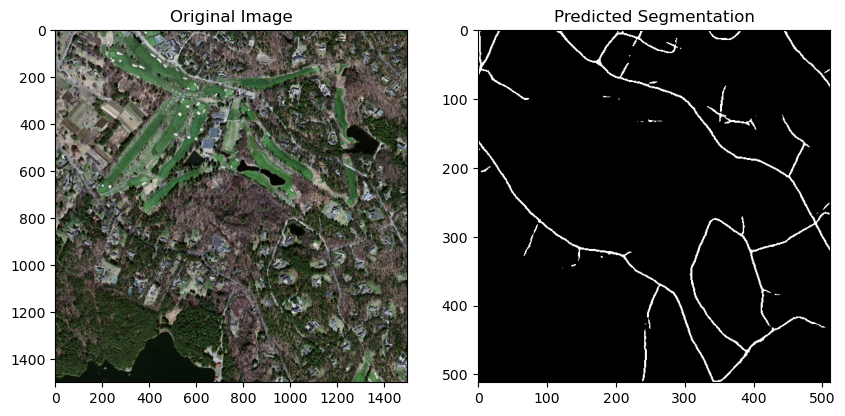

In [17]:
import matplotlib.pyplot as plt

def visualize_results(image_path, prediction):
    original_image = Image.open(image_path)
    plt.figure(figsize=(10, 5))
    
    # Imagen original
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(original_image)
    
    # Máscara predicha
    plt.subplot(1, 2, 2)
    plt.title("Predicted Segmentation")
    plt.imshow(prediction, cmap="gray")
    
    plt.show()

visualize_results(image_path, prediction)